## Find the ground state in (x1,x2) by PINN from a given Hamiltonian with unknown energe E

Using MPS device
Iteration 0: Loss = 14.523553, Energy = 1.001000, Norm Loss = 0.994792, Nontrivial Loss = 1.084297
Iteration 50: Loss = 3.827151, Energy = 1.053354, Norm Loss = 0.920514, Nontrivial Loss = 0.069695
Iteration 100: Loss = 1.715250, Energy = 1.109242, Norm Loss = 0.923617, Nontrivial Loss = 0.012662
Iteration 150: Loss = 1.308415, Energy = 1.144919, Norm Loss = 0.929228, Nontrivial Loss = 0.001634
Iteration 200: Loss = 1.138872, Energy = 1.171966, Norm Loss = 0.934743, Nontrivial Loss = 0.000565
Iteration 250: Loss = 1.141055, Energy = 1.196179, Norm Loss = 0.938452, Nontrivial Loss = 0.000509
Iteration 300: Loss = 1.074492, Energy = 1.218412, Norm Loss = 0.940572, Nontrivial Loss = 0.000085
Iteration 350: Loss = 1.059120, Energy = 1.239938, Norm Loss = 0.942480, Nontrivial Loss = 0.000079
Iteration 400: Loss = 1.037476, Energy = 1.259486, Norm Loss = 0.945205, Nontrivial Loss = 0.000031
Iteration 450: Loss = 1.030020, Energy = 1.279383, Norm Loss = 0.945890, Nontrivial L

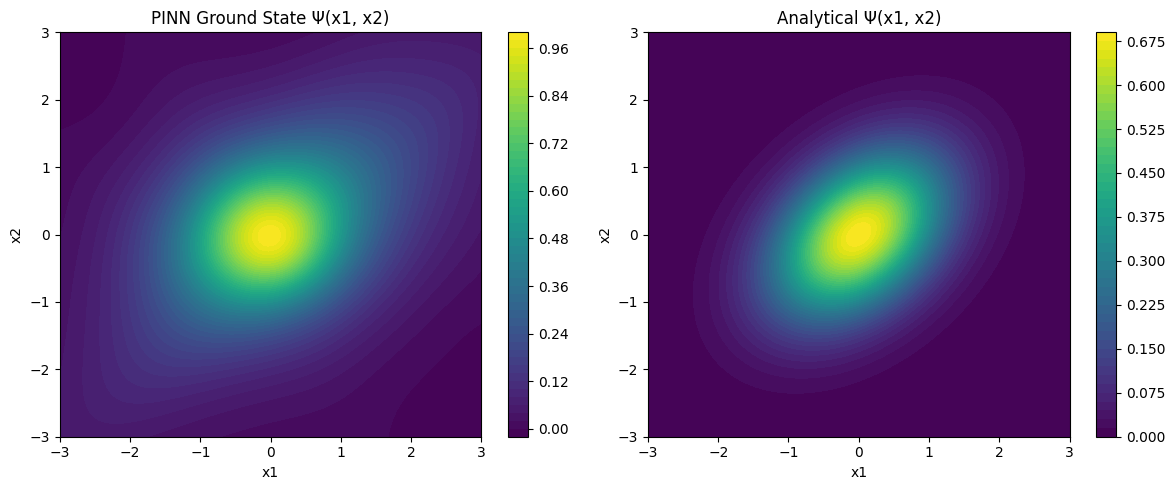

In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 设置环境变量，抑制MKL警告
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"

# 判断设备，启用 MPS（若支持）否则回退到 CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)

# --------------------------
# 定义 PINN 网络（MLP，全连接网络）
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50, num_hidden_layers=4, output_dim=1):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        out = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            out = self.activation(layer(out))
        out = self.output_layer(out)
        return out

# 将能量 E 定义为一个可学习参数（初始值1.0）
energy = torch.nn.Parameter(torch.tensor(1.0, dtype=torch.float32, device=device))

# --------------------------
# 定义 PDE 残差函数
def pde_residual(model, x, energy):
    # x: (N,2)
    x.requires_grad = True
    psi = model(x)

    # 计算一阶偏导
    grad_psi = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                   create_graph=True, retain_graph=True)[0]
    psi_x1 = grad_psi[:, 0:1]
    psi_x2 = grad_psi[:, 1:2]

    # 计算二阶偏导
    psi_x1x1 = torch.autograd.grad(psi_x1, x, grad_outputs=torch.ones_like(psi_x1),
                                   create_graph=True, retain_graph=True)[0][:, 0:1]
    psi_x2x2 = torch.autograd.grad(psi_x2, x, grad_outputs=torch.ones_like(psi_x2),
                                   create_graph=True, retain_graph=True)[0][:, 1:2]

    # 提取自变量 x1 和 x2
    x1 = x[:, 0:1]
    x2 = x[:, 1:2]

    # PDE: -1/2*(psi_x1x1+psi_x2x2) + 1/2*(x1^2+x2^2)*psi + (x1-x2)^2*psi = energy*psi
    residual = -0.5*(psi_x1x1 + psi_x2x2) + 0.5*(x1**2+x2**2)*psi + (x1-x2)**2*psi - energy * psi
    return residual

# --------------------------
# 生成训练数据：内部 collocation 点与边界点
def generate_training_data(N_inner=10000, N_b=2000, domain=(-5,5)):
    x_low, x_high = domain
    x_inner = np.random.uniform(x_low, x_high, (N_inner,2))
    # 边界采样：令 x1 或 x2 取边界值
    xb1 = np.random.uniform(x_low, x_high, (N_b//2, 1))
    xb2 = np.random.uniform(x_low, x_high, (N_b//2, 1))
    b1 = np.hstack((np.full((N_b//2,1), x_low), xb2))
    b2 = np.hstack((np.full((N_b//2,1), x_high), xb2))
    b3 = np.hstack((xb1, np.full((N_b//2,1), x_low)))
    b4 = np.hstack((xb1, np.full((N_b//2,1), x_high)))
    x_bound = np.vstack([b1, b2, b3, b4])
    # 转换为 tensor 并放到 device 上
    x_inner = torch.tensor(x_inner, dtype=torch.float32, device=device)
    x_bound = torch.tensor(x_bound, dtype=torch.float32, device=device)
    return x_inner, x_bound

# --------------------------
# 归一化惩罚项（在 collocation 点上使 wave function 平方平均约等于 1）
def normalization_loss(model, x):
    psi = model(x)
    norm_val = torch.mean(psi**2)
    return (norm_val - 1.0)**2

# --------------------------
# 非平凡点值约束：例如强制要求 Ψ(0,0)=1
def nontrivial_loss(model):
    pt0 = torch.tensor([[0.0, 0.0]], dtype=torch.float32, device=device)
    return (model(pt0) - 1.0)**2

# --------------------------
# 初始化模型与优化器
model = PINN().to(device)
optimizer = optim.Adam(list(model.parameters()) + [energy], lr=1e-3)

x_inner, x_bound = generate_training_data()

# --------------------------
# 训练循环
num_iterations = 500
for it in range(num_iterations):
    optimizer.zero_grad()

    # PDE 残差在内部点
    res = pde_residual(model, x_inner, energy)
    loss_interior = torch.mean(res**2)

    # 边界条件损失：要求边界上 Ψ -> 0
    psi_bound = model(x_bound)
    loss_boundary = torch.mean(psi_bound**2)

    # 归一化损失
    loss_norm = normalization_loss(model, x_inner)

    # 非平凡解约束，避免陷入零解
    loss_nontrivial = nontrivial_loss(model)

    # 总损失：可根据需要调整各部分系数
    loss = loss_interior + loss_boundary + 1.0 * loss_norm + 10.0 * loss_nontrivial
    loss.backward()
    optimizer.step()

    if it % 50 == 0:
        print(f"Iteration {it}: Loss = {loss.item():.6f}, Energy = {energy.item():.6f}, Norm Loss = {loss_norm.item():.6f}, Nontrivial Loss = {loss_nontrivial.item():.6f}")

print(f"Trained ground state energy (PINN): {energy.item():.6f}")

# --------------------------
# 绘图对比 PINN 与解析解
# 在 (x1, x2) 平面上构建网格，然后计算 PINN 波函数与解析解

N_plot = 100
x1_lin = np.linspace(-3, 3, N_plot)
x2_lin = np.linspace(-3, 3, N_plot)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

# 转换为 tensor
grid_points = np.vstack((X1.flatten(), X2.flatten())).T
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

# PINN 预测值
model.eval()
with torch.no_grad():
    psi_pinn = model(grid_tensor).cpu().numpy().reshape(N_plot, N_plot)

# --------------------------
# 解析解计算
# 解析解： Ψ(x1,x2) = ψ_cm((x1+x2)/2) * ψ_rel(x1-x2)
# ψ_cm(X) = (2/π)^(1/4) * exp(-X^2)
# ψ_rel(x) = ((sqrt(5)/(2π))^(1/4)) * exp(-sqrt(5)*x^2/4)
def analytic_wavefunction(x1, x2):
    X = (x1 + x2) / 2.0
    x = x1 - x2
    psi_cm = (2/np.pi)**0.25 * np.exp(-X**2)
    psi_rel = ((np.sqrt(5)/(2*np.pi))**0.25) * np.exp(-np.sqrt(5)*x**2/4)
    return psi_cm * psi_rel

psi_analytic = analytic_wavefunction(X1, X2)

# --------------------------
# 绘制 contour 图对比
fig, axs = plt.subplots(1, 2, figsize=(12,5))
cs1 = axs[0].contourf(X1, X2, psi_pinn, 50, cmap='viridis')
axs[0].set_title("PINN Ground State Ψ(x1, x2)")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
fig.colorbar(cs1, ax=axs[0])

cs2 = axs[1].contourf(X1, X2, psi_analytic, 50, cmap='viridis')
axs[1].set_title("Analytical Ψ(x1, x2)")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
fig.colorbar(cs2, ax=axs[1])

plt.tight_layout()
plt.show()


Using MPS device
Iteration 0: Loss = 24.469479, E_var = 24.466782, Boundary Loss = 0.002697
Iteration 50: Loss = 5.196869, E_var = 5.195048, Boundary Loss = 0.001821
Iteration 100: Loss = 3.462355, E_var = 3.461950, Boundary Loss = 0.000405
Iteration 150: Loss = 2.837692, E_var = 2.837394, Boundary Loss = 0.000298
Iteration 200: Loss = 2.785141, E_var = 2.784890, Boundary Loss = 0.000250
Iteration 250: Loss = 2.569946, E_var = 2.569723, Boundary Loss = 0.000223
Iteration 300: Loss = 2.239172, E_var = 2.239048, Boundary Loss = 0.000124
Iteration 350: Loss = 2.325517, E_var = 2.325379, Boundary Loss = 0.000138
Iteration 400: Loss = 1.931304, E_var = 1.931251, Boundary Loss = 0.000053
Iteration 450: Loss = 2.501583, E_var = 2.501467, Boundary Loss = 0.000117
Trained ground state energy (Variational PINN): 2.023693


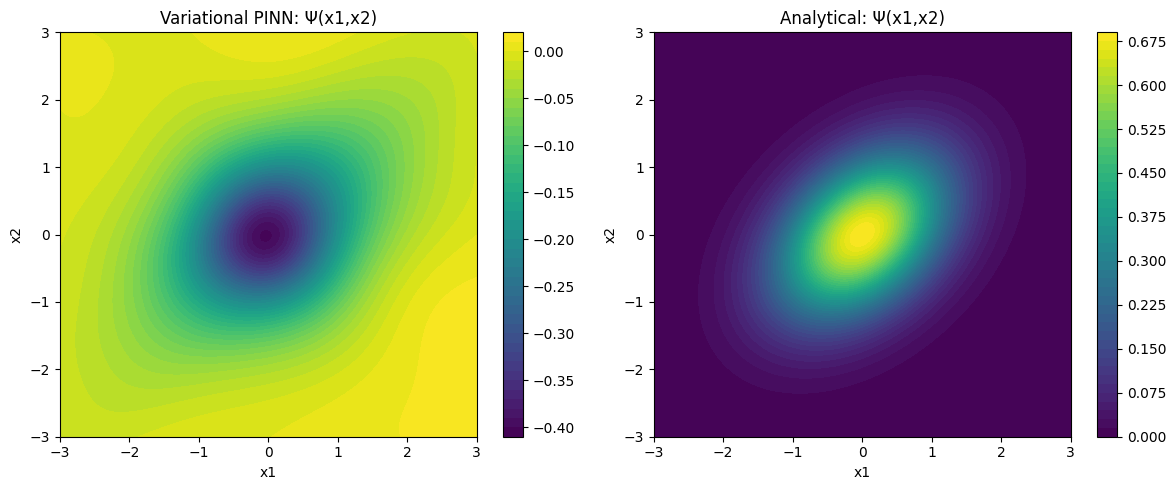

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 设置环境变量以抑制部分MKL警告
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"

# 选择设备：如果macOS支持MPS则使用MPS，否则使用CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)

# --------------------------
# 定义 PINN 网络（全连接神经网络/MLP）
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=50, num_hidden_layers=4, output_dim=1):
        super(PINN, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim)
                                            for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        # x: shape (N,2)
        out = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            out = self.activation(layer(out))
        out = self.output_layer(out)
        return out

# --------------------------
# 定义函数计算 Hψ，其中 H = -1/2 Δ + V, V(x1,x2)=1/2*(x1^2+x2^2)+(x1-x2)^2
def H_psi(model, x):
    # x: (N,2)
    x.requires_grad = True
    psi = model(x)

    # 计算一阶偏导数
    grad_psi = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                   create_graph=True, retain_graph=True)[0]
    psi_x1 = grad_psi[:, 0:1]
    psi_x2 = grad_psi[:, 1:2]

    # 二阶偏导
    psi_x1x1 = torch.autograd.grad(psi_x1, x, grad_outputs=torch.ones_like(psi_x1),
                                   create_graph=True, retain_graph=True)[0][:, 0:1]
    psi_x2x2 = torch.autograd.grad(psi_x2, x, grad_outputs=torch.ones_like(psi_x2),
                                   create_graph=True, retain_graph=True)[0][:, 1:2]

    # 提取 x1, x2
    x1 = x[:, 0:1]
    x2 = x[:, 1:2]

    # 定义势能: V = 1/2*(x1^2+x2^2)+(x1-x2)^2
    V = 0.5 * (x1**2 + x2**2) + (x1 - x2)**2

    # 计算 Hψ
    Hpsi = -0.5 * (psi_x1x1 + psi_x2x2) + V * psi
    return Hpsi

# --------------------------
# 利用 Monte Carlo 近似计算 Rayleigh 商
def variational_energy(model, x):
    # 在内部 collocation 点上，近似积分（均值近似）
    psi = model(x)
    Hpsi = H_psi(model, x)
    # 注意这里用均值近似积分
    numerator = torch.mean(psi * Hpsi)
    denominator = torch.mean(psi**2)
    # 为防止数值问题，加一个很小的数 eps
    eps = 1e-8
    E_var = numerator / (denominator + eps)
    return E_var

# --------------------------
# 生成训练数据：内部点和边界点
def generate_training_data(N_inner=10000, N_b=2000, domain=(-5, 5)):
    x_low, x_high = domain
    # 内部均匀采样
    x_inner = np.random.uniform(x_low, x_high, (N_inner, 2))
    # 边界点（取 x1 或 x2 为边界）
    xb1 = np.random.uniform(x_low, x_high, (N_b//2, 1))
    xb2 = np.random.uniform(x_low, x_high, (N_b//2, 1))
    b1 = np.hstack((np.full((N_b//2, 1), x_low), xb2))
    b2 = np.hstack((np.full((N_b//2, 1), x_high), xb2))
    b3 = np.hstack((xb1, np.full((N_b//2, 1), x_low)))
    b4 = np.hstack((xb1, np.full((N_b//2, 1), x_high)))
    x_bound = np.vstack([b1, b2, b3, b4])
    # 转为 tensor 并放到 device 上
    x_inner = torch.tensor(x_inner, dtype=torch.float32, device=device)
    x_bound = torch.tensor(x_bound, dtype=torch.float32, device=device)
    return x_inner, x_bound

# --------------------------
# 定义边界损失：在边界上要求 ψ(x)=0
def boundary_loss(model, x_bound):
    psi_bound = model(x_bound)
    return torch.mean(psi_bound**2)

# --------------------------
# 初始化模型与优化器
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_inner, x_bound = generate_training_data()

# --------------------------
# 训练 Variational PINN
num_iterations = 500
for it in range(num_iterations):
    optimizer.zero_grad()

    # 计算变分能量（Rayleigh 商），这是目标 loss
    E_var = variational_energy(model, x_inner)

    # 添加边界惩罚（使得波函数在边界处尽量为零）
    loss_bound = boundary_loss(model, x_bound)

    # 总损失：只以能量作为目标，同时用一个较小的权重控制边界条件（例如权重 λ_boundary = 1.0）
    loss = E_var + 1.0 * loss_bound
    loss.backward()
    optimizer.step()

    if it % 50 == 0:
        print(f"Iteration {it}: Loss = {loss.item():.6f}, E_var = {E_var.item():.6f}, Boundary Loss = {loss_bound.item():.6f}")

print(f"Trained ground state energy (Variational PINN): {variational_energy(model, x_inner).item():.6f}")

# --------------------------
# 绘图对比 PINN 与解析解
# 在 (x1,x2) 平面上构建网格，计算 PINN 波函数和解析解
N_plot = 100
x1_lin = np.linspace(-3, 3, N_plot)
x2_lin = np.linspace(-3, 3, N_plot)
X1, X2 = np.meshgrid(x1_lin, x2_lin)
grid_points = np.vstack((X1.flatten(), X2.flatten())).T
grid_tensor = torch.tensor(grid_points, dtype=torch.float32, device=device)

# PINN 预测值
model.eval()
with torch.no_grad():
    psi_pinn = model(grid_tensor).cpu().numpy().reshape(N_plot, N_plot)

# --------------------------
# 解析解计算：利用 center-of-mass 与 relative coordinates
# 定义：
#   X = (x1+x2)/2,      psi_cm(X) = (2/π)^(1/4) * exp(-X^2)
#   x = x1-x2,         psi_rel(x) = ((sqrt(5)/(2π))^(1/4)) * exp(-sqrt(5)*x^2/4)
def analytic_wavefunction(x1, x2):
    X = (x1 + x2) / 2.0
    x = x1 - x2
    psi_cm = (2/np.pi)**0.25 * np.exp(-X**2)
    psi_rel = ((np.sqrt(5)/(2*np.pi))**0.25) * np.exp(-np.sqrt(5)*x**2/4)
    return psi_cm * psi_rel

psi_analytic = analytic_wavefunction(X1, X2)

# --------------------------
# 绘制两幅等高线图对比
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cs1 = axs[0].contourf(X1, X2, psi_pinn, 50, cmap='viridis')
axs[0].set_title("Variational PINN: Ψ(x1,x2)")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
fig.colorbar(cs1, ax=axs[0])

cs2 = axs[1].contourf(X1, X2, psi_analytic, 50, cmap='viridis')
axs[1].set_title("Analytical: Ψ(x1,x2)")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
fig.colorbar(cs2, ax=axs[1])

plt.tight_layout()
plt.show()


## Use PINN to solve TDSE

Epoch 0, Loss: 1.69553e-01
Epoch 50, Loss: 2.41065e-02
Epoch 100, Loss: 1.65780e-02
Epoch 150, Loss: 1.21252e-02
Epoch 200, Loss: 8.41994e-03
Epoch 250, Loss: 8.16462e-03
Epoch 300, Loss: 6.25926e-03
Epoch 350, Loss: 5.54924e-03
Epoch 400, Loss: 8.27983e-03
Epoch 450, Loss: 4.91053e-03
Epoch 500, Loss: 4.42345e-03
Epoch 550, Loss: 4.01551e-03
Epoch 600, Loss: 3.64229e-03
Epoch 650, Loss: 1.42892e-02
Epoch 700, Loss: 3.45364e-03
Epoch 750, Loss: 3.07151e-03
Epoch 800, Loss: 2.77806e-03
Epoch 850, Loss: 2.51441e-03
Epoch 900, Loss: 3.56240e-03
Epoch 950, Loss: 2.74524e-03
开始 LBFGS 优化...
LBFGS 优化结束。


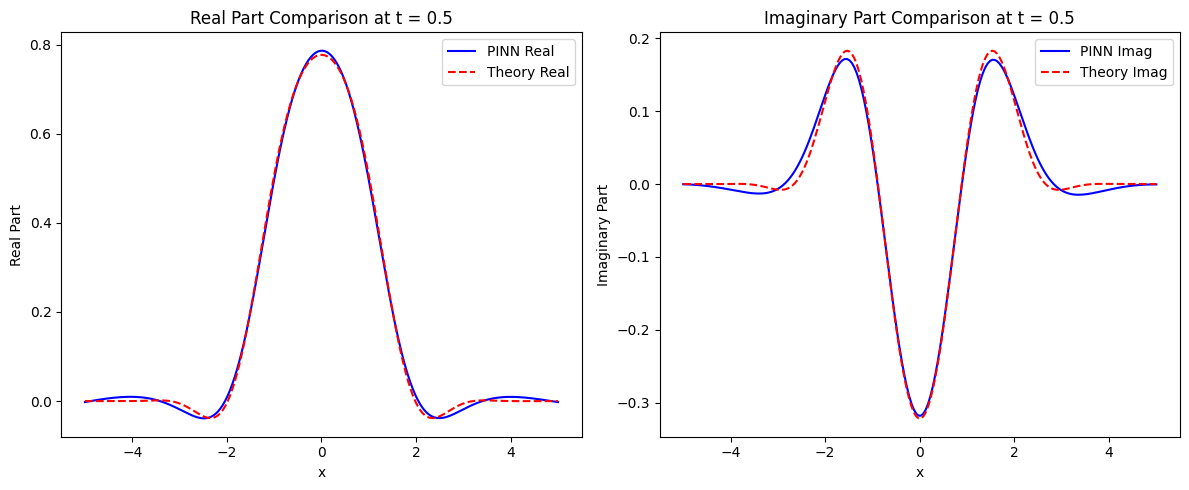

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# 物理常量和势能函数
# -----------------------
hbar = 1.0      # 约化普朗克常数
m = 1.0         # 质量

def V(x, t):
    # 自由粒子问题：势能函数 V=0
    return 0 * x

def psi0(x):
    # 初始条件：高斯波包 psi(x,0)=exp(-x^2)
    u0 = torch.exp(-x**2)
    v0 = torch.zeros_like(x)
    return u0, v0

# ----------------------------------
# 定义复值神经网络（分离实部和虚部）
# ----------------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        """
        layers: list，定义每层的神经元个数，例如 [2, 50, 50, 2]
                输入2维 (x, t)；输出2维 (u, v)
        """
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers)-1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x, t):
        """
        输入: x, t 均为 tensor，形状为 (N, 1)
        输出: u, v 均为 tensor，形状为 (N, 1)
        """
        inputs = torch.cat([x, t], dim=1)  # 拼接输入 (N,2)
        for i in range(len(self.layers)-1):
            inputs = self.activation(self.layers[i](inputs))
        outputs = self.layers[-1](inputs)   # 输出层不使用激活函数
        u = outputs[:, 0:1]
        v = outputs[:, 1:2]
        return u, v

# ----------------------------------
# 辅助函数：计算导数（使用自动微分）
# ----------------------------------
def gradients(u, x, order=1):
    if order == 1:
        grad = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        return grad
    elif order == 2:
        grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        grad2 = torch.autograd.grad(grad_u, x, grad_outputs=torch.ones_like(grad_u), retain_graph=True, create_graph=True)[0]
        return grad2
    else:
        raise ValueError("不支持的导数阶数")

# ----------------------------------
# 定义 TDSE 的残差函数
# 对于 ψ = u + i*v，拆分得到：
#    实部: - hbar*v_t + (hbar^2/(2*m))*u_xx - V*u = 0
#    虚部:   hbar*u_t + (hbar^2/(2*m))*v_xx - V*v = 0
# ----------------------------------
def tdse_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u, v = model(x, t)

    u_t = gradients(u, t, order=1)
    v_t = gradients(v, t, order=1)
    u_xx = gradients(u, x, order=2)
    v_xx = gradients(v, x, order=2)

    V_val = V(x, t)
    R_real = - hbar * v_t + (hbar**2/(2*m)) * u_xx - V_val * u
    R_imag =   hbar * u_t + (hbar**2/(2*m)) * v_xx - V_val * v

    return R_real, R_imag

# ---------------------------
# 数据采样（collocation, 初始和边界条件）
# ---------------------------
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# 神经网络结构设置，例如 [2, 50, 50, 2]
layers = [2, 200, 200, 200, 2]
model = PINN(layers).to(device)

# 设定 collocation 点数量、初始条件和边界条件点数
num_collocation = 5000
num_initial = 200
num_boundary = 200

# Collocation 点: x ∈ [-5,5], t ∈ [0,1]
x_collocation = torch.linspace(-5, 5, int(np.sqrt(num_collocation)))
t_collocation = torch.linspace(0, 1, int(np.sqrt(num_collocation)))
Xc, Tc = torch.meshgrid(x_collocation, t_collocation, indexing='ij')
x_collocation = Xc.reshape(-1, 1).to(device)
t_collocation = Tc.reshape(-1, 1).to(device)

# 初始条件数据：t=0, x ∈ [-5,5]
x_initial = torch.linspace(-5, 5, num_initial).reshape(-1, 1).to(device)
t_initial = torch.zeros_like(x_initial).to(device)
u_initial, v_initial = psi0(x_initial)
u_initial = u_initial.to(device)
v_initial = v_initial.to(device)

# 边界条件数据（Dirichlet，设定ψ(x=-5,t)=ψ(x=5,t)=0）
x_boundary = torch.cat((torch.full((num_boundary//2, 1), -5.0),
                        torch.full((num_boundary//2, 1), 5.0)), dim=0).to(device)
t_boundary = torch.rand(num_boundary, 1).to(device)  # t 在 [0,1] 内随机采样
u_boundary = torch.zeros_like(x_boundary).to(device)
v_boundary = torch.zeros_like(x_boundary).to(device)

# ----------------------------------
# 定义损失函数（包含 PDE, 初始和边界条件）
# ----------------------------------
def loss_function(model):
    R_real, R_imag = tdse_residual(model, x_collocation, t_collocation)
    loss_pde = torch.mean(R_real**2) + torch.mean(R_imag**2)

    u_pred, v_pred = model(x_initial, t_initial)
    loss_ic = torch.mean((u_pred - u_initial)**2) + torch.mean((v_pred - v_initial)**2)

    u_b, v_b = model(x_boundary, t_boundary)
    loss_bc = torch.mean((u_b - u_boundary)**2) + torch.mean((v_b - v_boundary)**2)

    return loss_pde + loss_ic + loss_bc

# ---------------------------
# 训练 PINN 网络
# ---------------------------
# 预训练：使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# 细调：使用 LBFGS 优化器
def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_function(model)
    loss.backward()
    return loss

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500,
                              tolerance_grad=1e-9, tolerance_change=1e-9, history_size=50, line_search_fn="strong_wolfe")

print("开始 LBFGS 优化...")
optimizer_lbfgs.step(closure)
print("LBFGS 优化结束。")

# ---------------------------
# 预测与绘图比较
# ---------------------------
# 选择 t = 0.5 作为比较时刻，在 x ∈ [-5, 5] 生成测试点
x_test = torch.linspace(-5, 5, 200).reshape(-1, 1).to(device)
t_test = 0.5 * torch.ones_like(x_test).to(device)
u_pred, v_pred = model(x_test, t_test)
psi_pred = u_pred + 1j * v_pred

# 将预测结果转为 numpy 数组
x_test_np = x_test.detach().cpu().numpy().flatten()
u_pred_np = u_pred.detach().cpu().numpy().flatten()
v_pred_np = v_pred.detach().cpu().numpy().flatten()

# 计算理论解析解，采用：
# psi_th(x,t)=1/sqrt(1+2i*t)*exp(-x^2/(1+2i*t))
def psi_theory(x, t):
    # 保证计算为复数，使用 numpy
    t = np.array(t, dtype=np.complex128)
    factor = 1.0/np.sqrt(1 + 2j*t)
    return factor * np.exp(-x**2/(1+2j*t))

# 在 t=0.5 时计算理论解
t_val = 0.5
psi_th = psi_theory(x_test_np, t_val)
u_th = np.real(psi_th)
v_th = np.imag(psi_th)

# 绘图比较（实部与虚部）
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_test_np, u_pred_np, 'b-', label="PINN Real")
plt.plot(x_test_np, u_th, 'r--', label="Theory Real")
plt.xlabel("x")
plt.ylabel("Real Part")
plt.title("Real Part Comparison at t = 0.5")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_test_np, v_pred_np, 'b-', label="PINN Imag")
plt.plot(x_test_np, v_th, 'r--', label="Theory Imag")
plt.xlabel("x")
plt.ylabel("Imaginary Part")
plt.title("Imaginary Part Comparison at t = 0.5")
plt.legend()

plt.tight_layout()
plt.show()


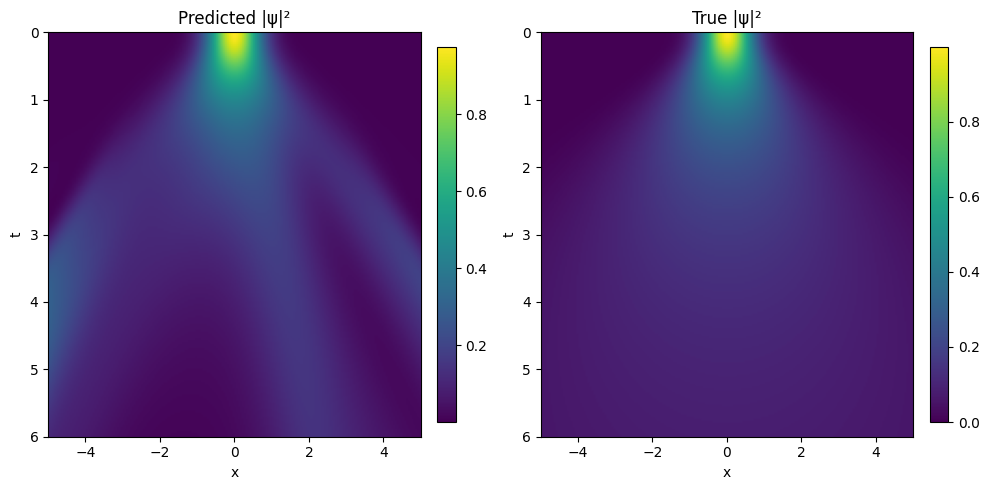

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经定义好了 PINN 模型： model
# 并且它的调用方式为:
#   u_pred, v_pred = model(x_tensor, t_tensor)
# 其中 x_tensor, t_tensor 的 shape 均为 (N, 1)

# ====== 1. 定义 (x, t) 网格  ======
x_min, x_max = -5.0, 5.0
t_min, t_max = 0.0, 6.0
Nx = 200  # x方向采样数
Nt = 200  # t方向采样数

x_lin = np.linspace(x_min, x_max, Nx)
t_lin = np.linspace(t_min, t_max, Nt)
X, T = np.meshgrid(x_lin, t_lin)   # X.shape=(Nt,Nx), T.shape=(Nt,Nx)

# 把 (Nt,Nx) 拉平成为 (Nt*Nx,1) 做批量预测
X_flat = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
T_flat = torch.tensor(T.reshape(-1, 1), dtype=torch.float32)

# 如果有 GPU，可以把数据搬到 device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_flat = X_flat.to(device)
T_flat = T_flat.to(device)

# ====== 2. 使用 PINN 模型做预测  ======
model.eval()  # 切换到推断模式
with torch.no_grad():
    u_pred, v_pred = model(X_flat, T_flat)
# 计算预测的 |psi|^2
u_pred_np = u_pred.cpu().numpy().flatten()
v_pred_np = v_pred.cpu().numpy().flatten()
psi_pred_sq = u_pred_np**2 + v_pred_np**2  # (Nt*Nx,)

# reshape 回 (Nt, Nx)
psi_pred_sq = psi_pred_sq.reshape(Nt, Nx)

# ====== 3. 计算理论/真实解并得到 |psi|^2  ======
def psi_theory(x, t):
    # 在此处写下你的理论解, 比如自由粒子波包, 此处仅举例
    # 例如: psi = exp( -x^2/(1+2i*t) ) / sqrt(1+2i*t)
    # 需要确保返回一个复数值数组 (或用复数的 np.complex)
    return np.exp(-x**2/(1.0 + 2.0*1j*t)) / np.sqrt(1.0+2.0*1j*t)

# 同样地, 计算 (Nt*Nx,) 大小的理论结果
X_np = X.reshape(-1)
T_np = T.reshape(-1)

psi_true = np.zeros_like(X_np, dtype=np.complex128)
for i in range(len(X_np)):
    psi_true[i] = psi_theory(X_np[i], T_np[i])

psi_true_sq = np.abs(psi_true)**2  # (Nt*Nx,)
psi_true_sq = psi_true_sq.reshape(Nt, Nx)

# ====== 4. 画出热力图比较  ======
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# (a) PINN预测结果
c1 = axes[0].imshow(psi_pred_sq,
                    extent=[x_min, x_max, t_max, t_min],
                    aspect='auto',
                    cmap='viridis')
axes[0].set_title("Predicted |ψ|²")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
fig.colorbar(c1, ax=axes[0], fraction=0.046, pad=0.04)

# (b) 理论/真实结果
c2 = axes[1].imshow(psi_true_sq,
                    extent=[x_min, x_max, t_max, t_min],
                    aspect='auto',
                    cmap='viridis')
axes[1].set_title("True |ψ|²")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
fig.colorbar(c2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


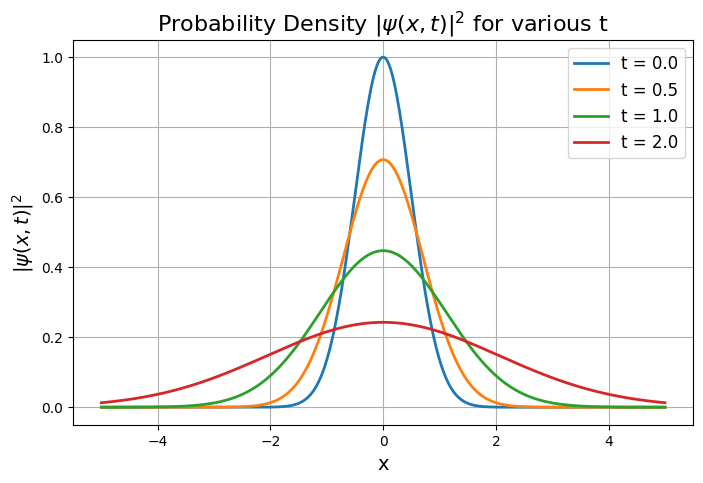

In [16]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 400)
times = [0.0, 0.5, 1.0, 2.0]  # 多个时刻

plt.figure(figsize=(8,5))
for t in times:
    psi_sq = (1/np.sqrt(1+4*t**2)) * np.exp(-2*x**2/(1+4*t**2))
    plt.plot(x, psi_sq, linewidth=2, label=r't = {:.1f}'.format(t))

plt.xlabel("x", fontsize=14)
plt.ylabel(r'$|\psi(x,t)|^2$', fontsize=14)
plt.title(r'Probability Density $|\psi(x,t)|^2$ for various t', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Epoch 0, Loss: 2.28718e+00
Epoch 100, Loss: 5.13552e-02
Epoch 200, Loss: 3.71609e-02
Epoch 300, Loss: 2.86502e-02
Epoch 400, Loss: 2.39061e-02
Epoch 500, Loss: 1.88424e-02
Epoch 600, Loss: 1.73766e-02
Epoch 700, Loss: 1.46954e-02
Epoch 800, Loss: 4.77235e-02
Epoch 900, Loss: 1.28304e-02
开始 LBFGS 优化...
LBFGS 优化结束。


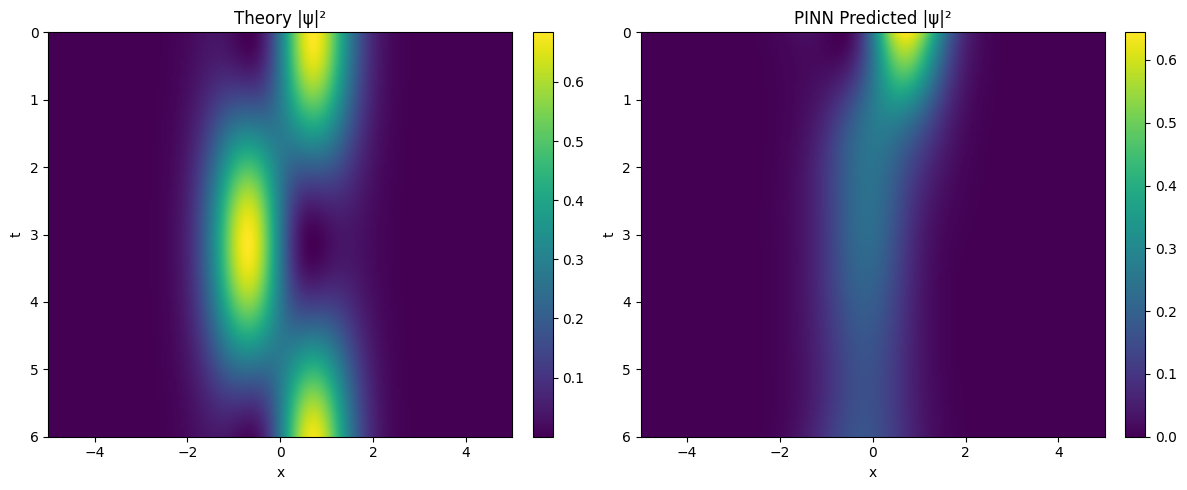

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 物理参数与势函数
# -----------------------
hbar = 1.0   # 约化普朗克常数
m = 1.0      # 质量

# 谐振子势能：V(x)=1/2*x^2（不依赖于t）
def V(x, t):
    return 0.5 * x**2

# -----------------------
# 初始条件：基态与第一激发态的叠加
# -----------------------
def psi0(x):
    # 注意：这里 x 为 tensor
    # 谐振子基态 psi_0(x) = 1/π^(1/4)*exp(-x^2/2)
    psi0_g = (1/np.pi**0.25) * torch.exp(-x**2/2)
    # 第一激发态 psi_1(x) = sqrt(2)/π^(1/4)* x * exp(-x^2/2)
    psi1 = (np.sqrt(2)/np.pi**0.25) * x * torch.exp(-x**2/2)
    # 叠加：系数取1/sqrt(2)
    u0 = (psi0_g + psi1) / np.sqrt(2)
    v0 = torch.zeros_like(u0)
    return u0, v0

# -----------------------
# 定义复值神经网络 (分离实部u和虚部v)
# -----------------------
class PINN(nn.Module):
    def __init__(self, layers):
        """
        layers: list，定义每层节点数，例如 [2, 50, 50, 2]
                输入为 (x,t), 输出为 (u,v)
        """
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # (N,2)
        for i in range(len(self.layers)-1):
            inputs = self.activation(self.layers[i](inputs))
        outputs = self.layers[-1](inputs)
        u = outputs[:, 0:1]
        v = outputs[:, 1:2]
        return u, v

# -----------------------
# 自动微分求导函数
# -----------------------
def gradients(u, x, order=1):
    if order == 1:
        grad = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   retain_graph=True, create_graph=True)[0]
        return grad
    elif order == 2:
        grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                     retain_graph=True, create_graph=True)[0]
        grad2 = torch.autograd.grad(grad_u, x, grad_outputs=torch.ones_like(grad_u),
                                    retain_graph=True, create_graph=True)[0]
        return grad2
    else:
        raise ValueError("仅支持一阶或二阶导数")

# -----------------------
# TDSE 残差函数
# 对于 ψ = u + i*v，分离后有：
#   实部:  - hbar*v_t + (hbar^2/(2*m))*u_xx - V*u = 0
#   虚部:    hbar*u_t + (hbar^2/(2*m))*v_xx - V*v = 0
# -----------------------
def tdse_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)

    u, v = model(x, t)
    u_t = gradients(u, t, order=1)
    v_t = gradients(v, t, order=1)
    u_xx = gradients(u, x, order=2)
    v_xx = gradients(v, x, order=2)

    V_val = V(x, t)

    R_real = - hbar * v_t + (hbar**2/(2*m))*u_xx - V_val * u
    R_imag =   hbar * u_t + (hbar**2/(2*m))*v_xx - V_val * v
    return R_real, R_imag

# -----------------------
# 数据采样：collocation, 初始, 边界条件
# -----------------------
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# 设置网络结构：输入2维，两个隐藏层各50个节点，输出2维
layers = [2, 200, 200, 200, 2]
model = PINN(layers).to(device)

# 采样数量
num_collocation = 5000   # 用于PDE残差的点
num_initial = 200         # 初始条件点
num_boundary = 200        # 边界条件点

# Collocation 点： x∈[-5,5], t∈[0, T_max]
x_collocation = torch.linspace(-5, 5, int(np.sqrt(num_collocation)))
t_collocation = torch.linspace(0, 6, int(np.sqrt(num_collocation)))  # T_max=6
Xc, Tc = torch.meshgrid(x_collocation, t_collocation, indexing='ij')
x_collocation = Xc.reshape(-1,1).to(device)
t_collocation = Tc.reshape(-1,1).to(device)

# 初始条件数据： t=0, x∈[-5,5]
x_initial = torch.linspace(-5,5, num_initial).reshape(-1,1).to(device)
t_initial = torch.zeros_like(x_initial).to(device)
u_initial, v_initial = psi0(x_initial)
u_initial = u_initial.to(device)
v_initial = v_initial.to(device)

# 边界条件数据（例如Dirichlet条件）：设定 ψ(x=-5,t)=ψ(x=5,t)=0
x_boundary = torch.cat((torch.full((num_boundary//2, 1), -5.0),
                        torch.full((num_boundary//2, 1), 5.0)), dim=0).to(device)
t_boundary = torch.rand(num_boundary, 1).to(device) * 6.0  # t∈[0,6]
u_boundary = torch.zeros_like(x_boundary).to(device)
v_boundary = torch.zeros_like(x_boundary).to(device)

# -----------------------
# 损失函数：包含 PDE, 初始条件, 边界条件项
# -----------------------
def loss_function(model):
    R_real, R_imag = tdse_residual(model, x_collocation, t_collocation)
    loss_pde = torch.mean(R_real**2) + torch.mean(R_imag**2)

    u_pred_ic, v_pred_ic = model(x_initial, t_initial)
    loss_ic = torch.mean((u_pred_ic - u_initial)**2) + torch.mean((v_pred_ic - v_initial)**2)

    u_pred_bc, v_pred_bc = model(x_boundary, t_boundary)
    loss_bc = torch.mean((u_pred_bc - u_boundary)**2) + torch.mean((v_pred_bc - v_boundary)**2)

    return loss_pde + loss_ic + loss_bc

# -----------------------
# 训练 PINN 模型
# -----------------------
# 预训练：使用 Adam 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# 细调：使用 LBFGS 优化器
def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_function(model)
    loss.backward()
    return loss

optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=500,
                              tolerance_grad=1e-9, tolerance_change=1e-9, history_size=50, line_search_fn="strong_wolfe")
print("开始 LBFGS 优化...")
optimizer_lbfgs.step(closure)
print("LBFGS 优化结束。")

# -----------------------
# 理论解析解：谐振子能量本征态的线性组合
# -----------------------
def psi_theory(x, t):
    # x: numpy数组, t: 标量
    # 基态
    psi0_g = (1/np.pi**0.25)*np.exp(-x**2/2)
    # 第一激发态
    psi1 = (np.sqrt(2)/np.pi**0.25)*x*np.exp(-x**2/2)
    # 时间演化：E0=0.5, E1=1.5
    psi = (psi0_g*np.exp(-1j*0.5*t) + psi1*np.exp(-1j*1.5*t)) / np.sqrt(2)
    return psi

# -----------------------
# 绘图：构造 x-t 网格并比较 |ψ|² 的热力图（左：理论解；右：PINN 预测）
# -----------------------
x_min, x_max = -5.0, 5.0
t_min, t_max = 0.0, 6.0
Nx = 200   # x方向采样数
Nt = 200   # t方向采样数

x_lin = np.linspace(x_min, x_max, Nx)
t_lin = np.linspace(t_min, t_max, Nt)
X, T = np.meshgrid(x_lin, t_lin)  # X, T 均为 (Nt, Nx)

# --- 理论解 ---
# 对每个网格点计算 psi_theory
X_flat = X.reshape(-1)
T_flat = T.reshape(-1)
psi_true = np.zeros_like(X_flat, dtype=np.complex128)
for i in range(len(X_flat)):
    psi_true[i] = psi_theory(X_flat[i], T_flat[i])
psi_true_sq = np.abs(psi_true)**2
psi_true_sq = psi_true_sq.reshape(Nt, Nx)

# --- PINN 预测 ---
# 将 (x,t) 数据转为 tensor 并批量预测
X_tensor = torch.tensor(X.reshape(-1,1), dtype=torch.float32).to(device)
T_tensor = torch.tensor(T.reshape(-1,1), dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    u_pred, v_pred = model(X_tensor, T_tensor)
u_pred_np = u_pred.cpu().numpy().flatten()
v_pred_np = v_pred.cpu().numpy().flatten()
psi_pred_sq = u_pred_np**2 + v_pred_np**2
psi_pred_sq = psi_pred_sq.reshape(Nt, Nx)

# -----------------------
# 绘制热力图对比（纸上常见的2D图像）
# -----------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 理论解 |ψ|² 热力图
c1 = axes[0].imshow(psi_true_sq, extent=[x_min, x_max, t_max, t_min],
                    aspect='auto', cmap='viridis')
axes[0].set_title("Theory |ψ|²")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")
fig.colorbar(c1, ax=axes[0], fraction=0.046, pad=0.04)

# PINN 预测 |ψ|² 热力图
c2 = axes[1].imshow(psi_pred_sq, extent=[x_min, x_max, t_max, t_min],
                    aspect='auto', cmap='viridis')
axes[1].set_title("PINN Predicted |ψ|²")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")
fig.colorbar(c2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
